# Emotion Recognition from text

This code takes some data that I found on the internet with some text labeled with 5 emotions and then trains a neural network model with the data.

In [2]:
# Lets try and do some deep learning models in pycharm
# Importing the final data that we want to analyse

# give credit to https://github.com/rmohashi/emotion-from-tweet/blob/master/notebooks/Train%20Emotion%20Recognition%20Model.ipynb

import pandas as pd
import numpy as np

# download training and test data
train_df = pd.DataFrame(columns=['text', 'labels'])
test_df = pd.DataFrame(columns=['text', 'labels' ])
with open('data/train.txt', 'r', encoding='utf-8') as file:
    for line in file.readlines():
        train_df = train_df.append({'text': line.split(';')[0],
                                    'labels': line.split(';')[1][:-1]
                                    }, ignore_index=True)
with open('data/test.txt', 'r', encoding='utf-8') as file:
    for line in file.readlines():
        test_df = test_df.append({'text': line.split(';')[0],
                                 'labels': line.split(';')[1][:-1]
                                  }, ignore_index=True)

train_data = pd.read_csv('data/training_set.csv')
test_data = pd.read_csv('data/test_set.csv')

# We actually have 2 different sets but i am going to use the second one first because it has more lines
# we will see what happens

In [3]:
### Now we need to turn the text into numbers...
# The basic idea of word embedding is words that occur in similar context tend to be closer to each
# other in vector space. For generating word vectors in Python, modules needed are nltk and gensim.

# importing all necessary modules
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action='ignore')
import gensim
from gensim.models import Word2Vec
from pathlib import Path
import re
import nltk
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer



In [20]:
# Preparing the dataset
#all_sentences = nltk.sent_tokenize(all_data_string)
#all_words = [nltk.word_tokenize(sent) for sent in all_sentences]

def clean_data(data):
    # This function takes an array of strings and returns an array of cleaned up strings
    cleaned_data = []
    for row,texts in enumerate(data):
        texts = str(texts)
        texts = texts.lower()
        # remove special characters
        texts = texts.replace(r"(http|@)\S+", "")
        texts = texts.replace(r"::", " ")
        texts = texts.replace(r"’", "")
        texts = texts.replace(r",", " ")
        texts = texts.replace(r"[^a-z\':_]", " ")
        # remove repetition
        #pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
        #texts = texts.replace(pattern, r"\1")
        # Transform short negation form
        texts = texts.replace(r"(can't|cannot)", 'can not')
        texts = texts.replace(r"n't", ' not')
        # Remove stop words
        stopwords = nltk.corpus.stopwords.words('english')
        stopwords.remove('not')
        stopwords.remove('nor')
        stopwords.remove('no')
        cleaned_line = ''
        for word in texts.split(" "):
            if word not in stopwords:
                cleaned_line = cleaned_line + " " + word
        cleaned_data.append(cleaned_line)
    return cleaned_data


train_data['Text'] = clean_data(train_data['Text'])
test_data['Text'] = clean_data(test_data['Text'])

In [6]:
# Now that the data is cleaned up we need to tokenize it
num_words = 10000

tokenizer = Tokenizer(num_words=num_words, lower=True)
tokenizer.fit_on_texts(train_data.Text)

file_to_save = Path('../Mygov_feedback_outputs/models/tokenizer.pickle').resolve()
with file_to_save.open('wb') as file:
    pickle.dump(tokenizer, file)

In [7]:
# The data is tokenized - now lets try putting it in the model

from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, concatenate
from tensorflow.keras.models import Model

# define model params
input_dim = min(tokenizer.num_words, len(tokenizer.word_index) + 1)
num_classes = len(train_data.Emotion.unique())
embedding_dim = 500
input_length = 100
lstm_units = 128
lstm_dropout = 0.1
recurrent_dropout = 0.1
spatial_dropout=0.2
filters=64
kernel_size=3

In [8]:
# create model
input_layer = Input(shape=(input_length,))
output_layer = Embedding(
  input_dim=input_dim,
  output_dim=embedding_dim,
  input_shape=(input_length,)
)(input_layer)

output_layer = SpatialDropout1D(spatial_dropout)(output_layer)

output_layer = Bidirectional(
LSTM(lstm_units, return_sequences=True,
     dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)
)(output_layer)
output_layer = Conv1D(filters, kernel_size=kernel_size, padding='valid',
                    kernel_initializer='glorot_uniform')(output_layer)

avg_pool = GlobalAveragePooling1D()(output_layer)
max_pool = GlobalMaxPooling1D()(output_layer)
output_layer = concatenate([avg_pool, max_pool])

output_layer = Dense(num_classes, activation='softmax')(output_layer)

model = Model(input_layer, output_layer)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 500)     5000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 500)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 256)     644096      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [10]:
# Now lets prep the model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

# turn into arrays of words not strings
train_sequences = [text.split() for text in train_data.Text]
validation_sequences = [text.split() for text in test_data.Text]
# turn into array of integers
list_tokenized_train = tokenizer.texts_to_sequences(train_sequences)
list_tokenized_validation = tokenizer.texts_to_sequences(validation_sequences)
# pad out the arrays
x_train = pad_sequences(list_tokenized_train, maxlen=input_length)
x_validation = pad_sequences(list_tokenized_validation, maxlen=input_length)
# encode the data
encoder = LabelBinarizer()
encoder.fit(train_data.Emotion.unique())

encoder_path = Path('../Mygov_feedback_outputs/models', 'encoder.pickle')
with encoder_path.open('wb') as file:
    pickle.dump(encoder, file)

In [13]:
y_train = encoder.transform(train_data.Emotion)
y_validation = encoder.transform(test_data.Emotion)

# Ready to train the model now

batch_size = 128
epochs = 5

history = model.fit(
    x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_validation, y_validation)
)

Epoch 1/5
62/62 [==============================] - 32s 508ms/step - loss: 0.3086 - accuracy: 0.9036 - val_loss: 1.1057 - val_accuracy: 0.6785
Epoch 2/5
62/62 [==============================] - 33s 535ms/step - loss: 0.2269 - accuracy: 0.9299 - val_loss: 1.2502 - val_accuracy: 0.6684
Epoch 3/5
62/62 [==============================] - 32s 519ms/step - loss: 0.1837 - accuracy: 0.9427 - val_loss: 1.4093 - val_accuracy: 0.6658
Epoch 4/5
62/62 [==============================] - 32s 520ms/step - loss: 0.1497 - accuracy: 0.9555 - val_loss: 1.5956 - val_accuracy: 0.6581
Epoch 5/5
62/62 [==============================] - 32s 520ms/step - loss: 0.1331 - accuracy: 0.9609 - val_loss: 1.7031 - val_accuracy: 0.6611


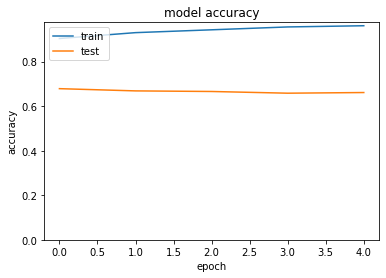

In [14]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(ymin=0)
plt.show()


In [45]:
survey_data = pd.read_excel('data/raw_data.xlsx')

columns_with_open_ended_data = ['Q02', 'Q04', 'Q06', 'Q08', 'Q10', 'Q12', 'Q14']
data = survey_data[columns_with_open_ended_data]
data = data.reset_index()
data = data[1:]
data = data.drop(columns = ['index'])
all_values = []
for column in data:
    this_column_values = data[column].tolist()
    all_values += this_column_values
one_column_df = pd.DataFrame(all_values)
one_column_df = one_column_df.dropna()
data = one_column_df.reset_index()
data = data.drop(columns = ['index'])
data = np.array(data)
data = clean_data(data)

In [73]:
# turn the data into a vector using the tokenizer from the model
def emotion_predictor(data):
    tokenizer.fit_on_texts(data)
    list_tokenized_data = tokenizer.texts_to_sequences(current_data)
    x_padded = pad_sequences(list_tokenized_data, maxlen=input_length)

    predicted = model.predict(x_padded)
    emotions_dictionary = { '1' : 'anger',
                            '2' : 'fear',
                            '3' : 'joy',
                            '4' : 'neutral',
                            '5' : 'sadness'}

    averages = predicted.mean(axis=0)
    emotions_df = pd.DataFrame(columns=['Emotion','Average'])
    
    for i,number in enumerate(averages):
        emotions_df = emotions_df.append({ 'Emotion' : emotions_dictionary[str(i+1)],
                                       'Average' : number},
                                     ignore_index=True)
    #print(emotions_dictionary[str(i+1)]," = ",number)
    emotions_df = emotions_df.set_index('Emotion')

    return emotions_df



In [84]:
columns_data = survey_data[columns_with_open_ended_data][1:]
emotions_questions = pd.DataFrame(columns=['Question', 'anger', 'fear', 'joy', 'neutral', 'sadness'])

for current_column in columns_data:
    current_data = columns_data['Q02']
    current_data = current_data.dropna()
    current_data.reset_index()
    current_data = current_data.drop(columns=['index'])
    current_data = current_data.to_list()
    current_data = np.array(current_data)
    #print(current_data)
    current_emotions = emotion_predictor(current_data)
    emotions_questions = emotions_questions.append({'Question' : current_column,
                                                   'anger': current_emotions.loc['anger'][0],
                                                   'fear': current_emotions.loc['fear'][0],
                                                   'joy': current_emotions.loc['joy'][0],
                                                   'neutral': current_emotions.loc['neutral'][0],
                                                   'sadness': current_emotions.loc['sadness'][0]
                                                   }, ignore_index= True)
emotions_questions = emotions_questions.append({'Question': 'Average',
                                                'anger': emotions_questions.mean()['anger'],
                                               'fear': emotions_questions.mean()['fear'],
                                               'joy': emotions_questions.mean()['joy'],
                                               'neutral': emotions_questions.mean()['neutral'],
                                               'sadness': emotions_questions.mean()['sadness']
                                               },ignore_index = True)

In [85]:
emotions_questions

,Question,anger,fear,joy,neutral,sadness
0,Q02,0.169689,0.255936,0.200030,0.052549,0.321795
1,Q04,0.154503,0.263786,0.167543,0.055680,0.358488
2,Q06,0.167076,0.257071,0.169077,0.047387,0.359389
3,Q08,0.154666,0.254881,0.163440,0.052702,0.374311
4,Q10,0.160799,0.252206,0.153849,0.061308,0.371837
5,Q12,0.160216,0.250237,0.151817,0.063602,0.374128
6,Q14,0.183793,0.238476,0.136337,0.063375,0.378018
7,Average,0.164392,0.253227,0.163156,0.056658,0.362567


In [86]:
emotions_questions.to_csv('data/output/recognized_emotions.csv')